<a href="https://colab.research.google.com/github/John1495/RNA-3D/blob/main/EDA_Analysis1_(RNA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install PyTorch Geometric and dependencies
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-geometric



Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.0/494.0 kB 6.7 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.3 MB/s eta 0:00:00


In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cpu.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cpu.html


Looking in links: https://data.pyg.org/whl/torch-2.1.0+cpu.html
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cpu.html


In [ ]:
# Install additional visualization packages
!pip install matplotlib missingno seaborn plotly networkx

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout


=== Initial Data Preview ===
   resid         ID resname        x_1        y_1     z_1
0      1   17RA_A_1       G  35.856998 -10.769000  -7.548
1     10  17RA_A_10       A  26.341999  12.365000  -0.594
2     11  17RA_A_11       U  23.917999  16.023001  -5.418
3     12  17RA_A_12       U  24.938000  15.565000 -11.243
4     13  17RA_A_13       A  25.587999  10.095000 -10.004

=== Data Statistics ===
               resid            x_1            y_1            z_1
count  137095.000000  130950.000000  130950.000000  130950.000000
mean      897.255633      80.447315      84.040727      98.611226
std      1014.321987     147.422319     114.928902     119.410665
min         1.000000    -821.085999    -449.414001    -333.403992
25%        61.000000      -1.115750      -4.890750       2.218500
50%       481.000000      62.651501      67.901501      72.938499
75%      1459.500000     178.809753     170.451996     184.531750
max      4298.000000     849.887024     889.507996     668.776978

==

<Figure size 1000x600 with 0 Axes>

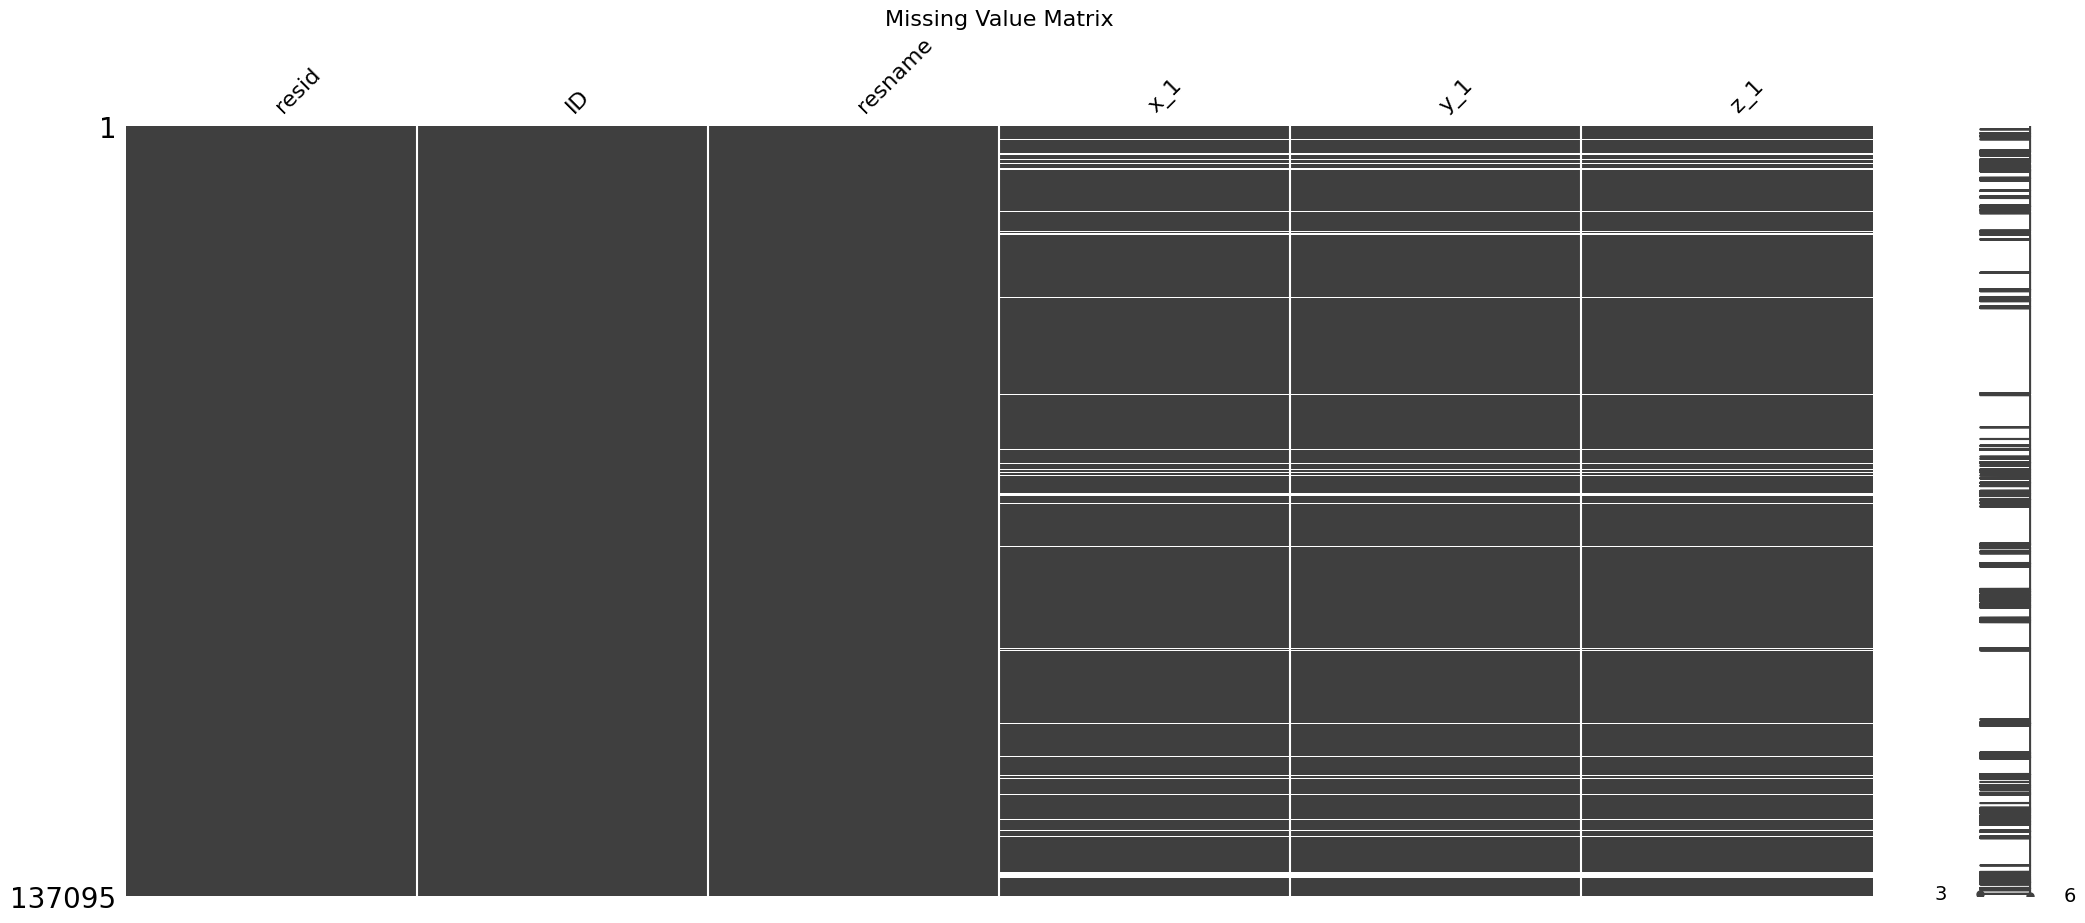

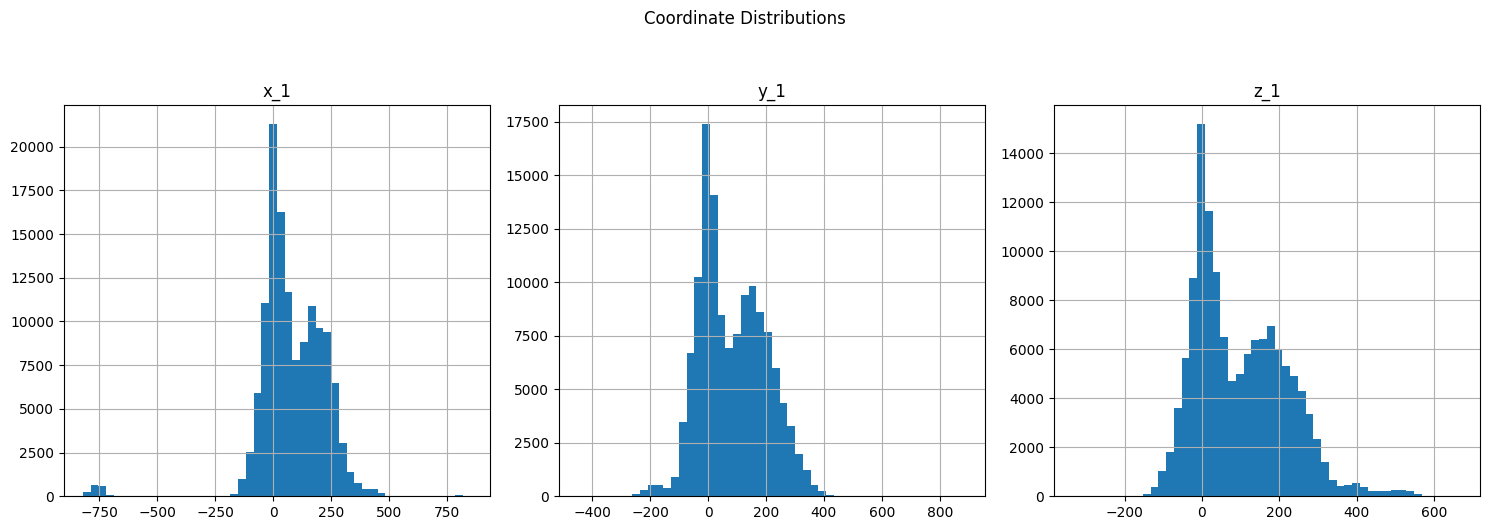

In [ ]:
# Load and visualize initial data
df = pd.read_csv('/kaggle/train_labels.csv')

print("\n=== Initial Data Preview ===")
print(df.head())

print("\n=== Data Statistics ===")
print(df.describe())

print("\n=== Missing Values ===")
print(df.isnull().sum())

# Missing data visualization
plt.figure(figsize=(10, 6))
msno.matrix(df)
plt.title('Missing Value Matrix', fontsize=16)
plt.show()

# Distribution of coordinates (non-missing values)
coord_cols = ['x_1', 'y_1', 'z_1']
df[coord_cols].dropna().hist(bins=50, figsize=(15, 5), layout=(1, 3))
plt.suptitle('Coordinate Distributions', y=1.05)
plt.tight_layout()
plt.show()

# 3D scatter plot of coordinates (sample)
sample_df = df.dropna().sample(n=1000, random_state=42)
fig = px.scatter_3d(sample_df, x='x_1', y='y_1', z='z_1',
                    color='resname', title='3D RNA Structure (Sample)')
fig.update_layout(scene=dict(aspectmode="cube"))
fig.show()

In [ ]:
print(df.head())
print(df.describe())
print(df['ID'].nunique())
print(df.isnull().sum())

   resid         ID resname        x_1        y_1     z_1
0      1   17RA_A_1       G  35.856998 -10.769000  -7.548
1     10  17RA_A_10       A  26.341999  12.365000  -0.594
2     11  17RA_A_11       U  23.917999  16.023001  -5.418
3     12  17RA_A_12       U  24.938000  15.565000 -11.243
4     13  17RA_A_13       A  25.587999  10.095000 -10.004
               resid            x_1            y_1            z_1
count  137095.000000  130950.000000  130950.000000  130950.000000
mean      897.255633      80.447315      84.040727      98.611226
std      1014.321987     147.422319     114.928902     119.410665
min         1.000000    -821.085999    -449.414001    -333.403992
25%        61.000000      -1.115750      -4.890750       2.218500
50%       481.000000      62.651501      67.901501      72.938499
75%      1459.500000     178.809753     170.451996     184.531750
max      4298.000000     849.887024     889.507996     668.776978
137095
resid         0
ID            0
resname       0
x_1

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

# Load the dataset
input_path = Path('/kaggle/train_labels.csv')
df = pd.read_csv(input_path)

# Define maximum gap length for interpolation
MAX_GAP = 5

def interpolate_group(group):
    grp = group.copy()
    # Identify where any coordinate is missing
    missing_mask = grp[['x_1', 'y_1', 'z_1']].isna().any(axis=1)

    # Identify continuous missing segments
    gaps = []
    current_gap = []
    for idx, miss in zip(grp.index, missing_mask):
        if miss:
            current_gap.append(idx)
        else:
            if current_gap:
                gaps.append(current_gap)
                current_gap = []
    if current_gap:
        gaps.append(current_gap)

    # Fill large gaps with group mean
    mean_vals = grp[['x_1', 'y_1', 'z_1']].mean()
    for gap in gaps:
        if len(gap) > MAX_GAP:
            grp.loc[gap, ['x_1', 'y_1', 'z_1']] = mean_vals.values

    # Interpolate remaining missing values by 'resid'
    grp = grp.set_index('resid')
    grp[['x_1', 'y_1', 'z_1']] = grp[['x_1', 'y_1', 'z_1']].interpolate(
        method='index', limit=MAX_GAP, limit_direction='both'
    )
    return grp.reset_index()

# Apply interpolation per ID (cleaner syntax to avoid warning)
df_imputed = (
    df.groupby('ID', group_keys=False)
      .apply(interpolate_group)
)

# Final fallback: fill any remaining NaNs with global mean
df_imputed[['x_1', 'y_1', 'z_1']] = df_imputed[['x_1', 'y_1', 'z_1']].fillna(
    df[['x_1', 'y_1', 'z_1']].mean()
)

# Check remaining missing
remaining_na = df_imputed[['x_1', 'y_1', 'z_1']].isna().sum()
print("Remaining missing after final cleaning:", remaining_na.to_dict())

# Save the cleaned dataset
output_path = Path('/kaggle/train_labels1.csv')
df_imputed.to_csv(output_path, index=False)
print("Cleaned data saved to:", output_path)


<ipython-input-24-2b683562aff4>:46: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Remaining missing after final cleaning: {'x_1': 0, 'y_1': 0, 'z_1': 0}
Cleaned data saved to: /kaggle/train_labels1.csv


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
import math

df= pd.read_csv('/kaggle/train_labels1.csv')

#print(df)
print(df.isnull().sum())

resid      0
ID         0
resname    0
x_1        0
y_1        0
z_1        0
dtype: int64



=== Initial Data Preview ===
   resid         ID resname        x_1        y_1     z_1
0      1   17RA_A_1       G  35.856998 -10.769000  -7.548
1     10  17RA_A_10       A  26.341999  12.365000  -0.594
2     11  17RA_A_11       U  23.917999  16.023001  -5.418
3     12  17RA_A_12       U  24.938000  15.565000 -11.243
4     13  17RA_A_13       A  25.587999  10.095000 -10.004

=== Data Statistics ===
               resid            x_1            y_1            z_1
count  137095.000000  137095.000000  137095.000000  137095.000000
mean      897.255633      80.447315      84.040727      98.611226
std      1014.321987     144.080467     112.323629     116.703797
min         1.000000    -821.085999    -449.414001    -333.403992
25%        61.000000       1.002500      -2.804500       4.136500
50%       481.000000      71.885002      80.323997      86.356003
75%      1459.500000     173.953003     165.981499     180.217003
max      4298.000000     849.887024     889.507996     668.776978

==

<Figure size 1000x600 with 0 Axes>

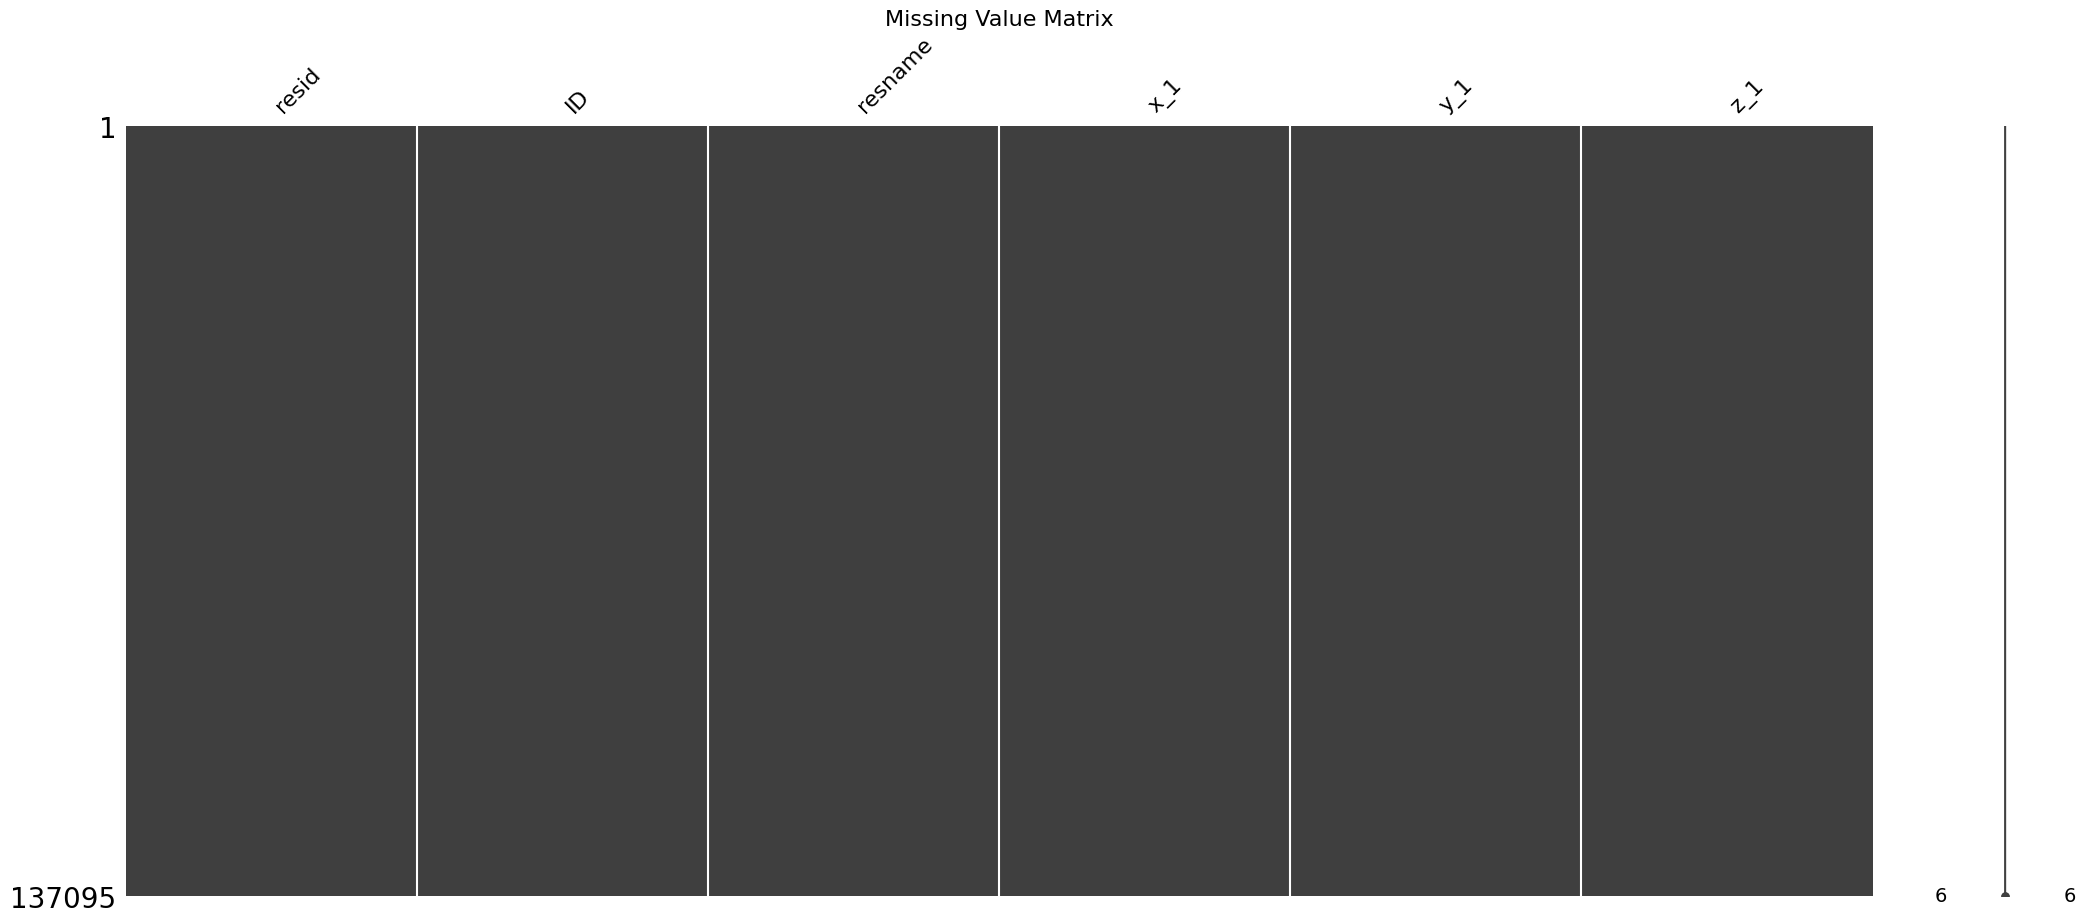

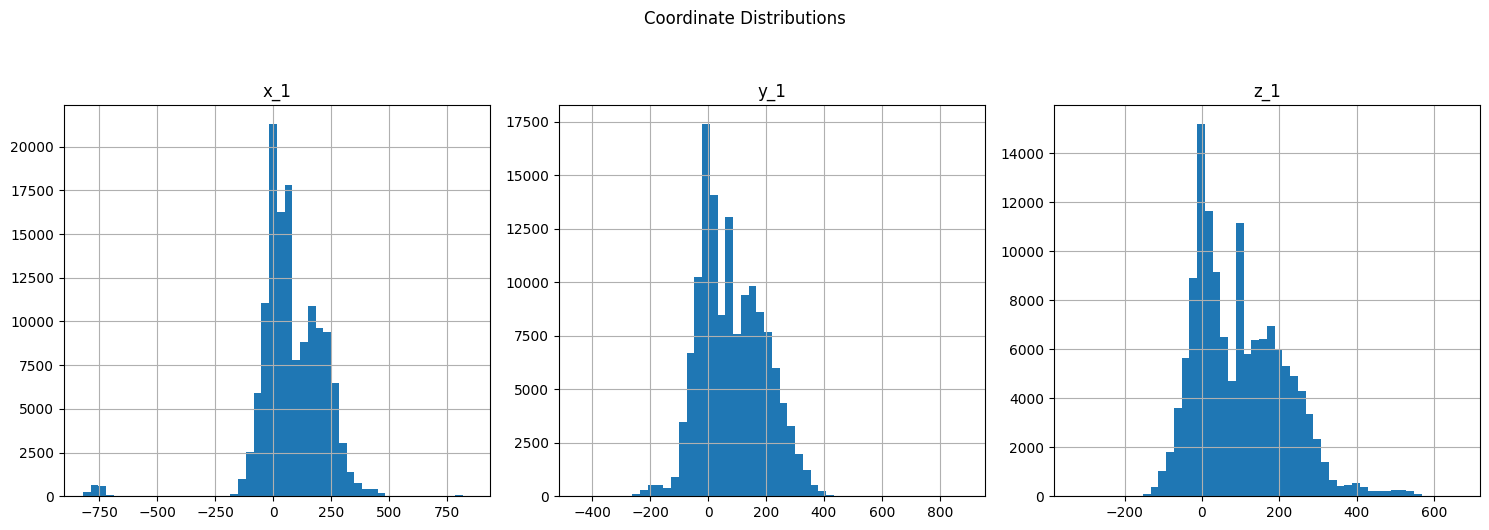

In [ ]:
# Load and visualize initial data
df = pd.read_csv('/kaggle/train_labels1.csv')

print("\n=== Initial Data Preview ===")
print(df.head())

print("\n=== Data Statistics ===")
print(df.describe())

print("\n=== Missing Values ===")
print(df.isnull().sum())

# Missing data visualization
plt.figure(figsize=(10, 6))
msno.matrix(df)
plt.title('Missing Value Matrix', fontsize=16)
plt.show()

# Distribution of coordinates (non-missing values)
coord_cols = ['x_1', 'y_1', 'z_1']
df[coord_cols].dropna().hist(bins=50, figsize=(15, 5), layout=(1, 3))
plt.suptitle('Coordinate Distributions', y=1.05)
plt.tight_layout()
plt.show()

# 3D scatter plot of coordinates (sample)
sample_df = df.dropna().sample(n=1000, random_state=42)
fig = px.scatter_3d(sample_df, x='x_1', y='y_1', z='z_1',
                    color='resname', title='3D RNA Structure (Sample)')
fig.update_layout(scene=dict(aspectmode="cube"))
fig.show()

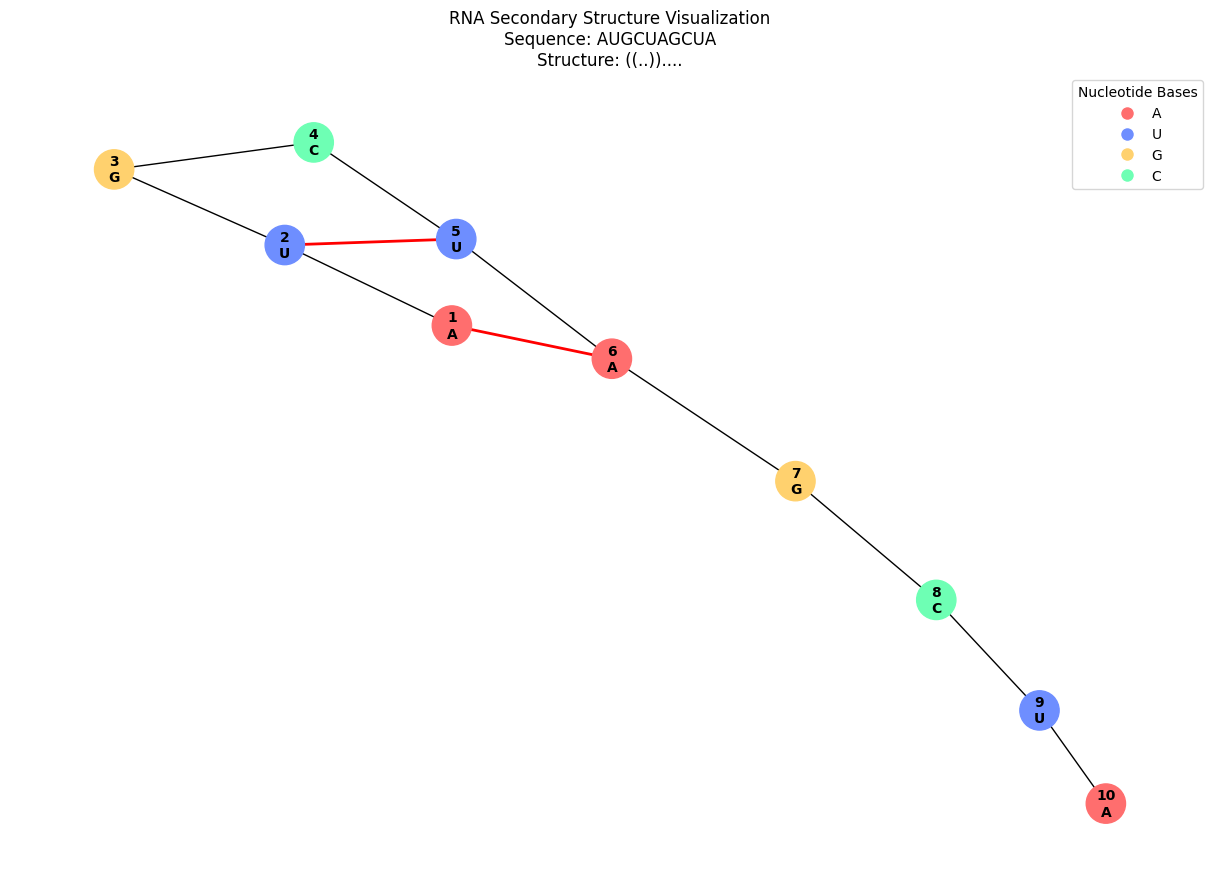

In [ ]:
# Enhanced sequence and structure visualization
def visualize_rna_structure(sequence, structure):
    # Parse structure
    pairs = parse_dot_bracket(structure)

    # Create graph
    G = nx.Graph()

    # Add nodes with sequence positions
    for i, base in enumerate(sequence):
        G.add_node(i, base=base, pos=i)

    # Add edges
    for i in range(len(sequence)-1):
        G.add_edge(i, i+1, color='black', weight=1)  # Backbone

    for i, j in pairs.items():
        if i < j:  # Avoid duplicate edges
            G.add_edge(i, j, color='red', weight=2)  # Base pairs

    # Node colors by base type
    base_colors = {'A': '#FF6E6E', 'U': '#6E8EFF', 'G': '#FFD16E', 'C': '#6EFFB4'}
    node_colors = [base_colors[base] for base in sequence]

    # Edge colors
    edge_colors = [G[u][v]['color'] for u,v in G.edges()]
    edge_weights = [G[u][v]['weight'] for u,v in G.edges()]

    # Layout
    pos = nx.spring_layout(G, seed=42)

    # Plot
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, labels={i: f"{i+1}\n{base}" for i, base in enumerate(sequence)},
            node_color=node_colors, edge_color=edge_colors, width=edge_weights,
            node_size=800, font_size=10, font_weight='bold')

    # Add legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=base,
                                 markerfacecolor=color, markersize=10)
                      for base, color in base_colors.items()]
    plt.legend(handles=legend_elements, title='Nucleotide Bases')

    plt.title(f"RNA Secondary Structure Visualization\nSequence: {sequence}\nStructure: {structure}")
    plt.show()

# Example usage
sequence = "AUGCUAGCUA"
dot_bracket = "((..))...."
visualize_rna_structure(sequence, dot_bracket)

In [ ]:


# Example RNA sequence
sequence = "AUGCUAGCUA"

# One-hot encode A/U/G/C
base_to_idx = {'A': 0, 'U': 1, 'G': 2, 'C': 3}
one_hot = torch.eye(4)[[base_to_idx[base] for base in sequence]]  # Shape: [L, 4]

# Sinusoidal positional encoding
def get_sinusoidal_pos_enc(length, dim=4):
    pos = np.arange(length)[:, np.newaxis]
    i = np.arange(dim)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / dim)
    angle_rads = pos * angle_rates
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return torch.tensor(angle_rads, dtype=torch.float)

pos_enc = get_sinusoidal_pos_enc(len(sequence), dim=4)  # Shape: [L, 4]

# Final node features = concat base one-hot + pos encoding
node_features = torch.cat([one_hot, pos_enc], dim=1)  # Shape: [L, 8]


In [ ]:
def parse_dot_bracket(structure):
    stack = []
    pairs = {}
    for i, char in enumerate(structure):
        if char == '(':
            stack.append(i)
        elif char == ')':
            j = stack.pop()
            pairs[i] = j
            pairs[j] = i
    return pairs  # dict of base pair positions

dot_bracket = "((..))...."
base_pairs = parse_dot_bracket(dot_bracket)  # {0: 5, 1: 4, 4: 1, 5: 0}

# Sequential edges (i, i+1)
seq_edges = [(i, i+1) for i in range(len(sequence)-1)]
seq_edges += [(i+1, i) for i in range(len(sequence)-1)]

# Base pair edges
pair_edges = [(i, j) for i, j in base_pairs.items()]
edges = list(set(seq_edges + pair_edges))

# Convert to tensor
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()  # Shape: [2, num_edges]


In [ ]:
# Dummy distance matrix
L = len(sequence)
dist_matrix = torch.rand((L, L))  # Normally from structure prediction or geometry prior

# Threshold-based spatial edges (if needed)
threshold = 8.0
spatial_edges = [(i, j) for i in range(L) for j in range(L) if dist_matrix[i, j] < threshold and i != j]


In [ ]:
from torch_geometric.data import Data

data = Data(x=node_features, edge_index=edge_index)  # Add edge_attr if needed